In [1]:
import pandas as pd
import numpy as np
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak
import matplotlib.pyplot as plt
from IPython.display import Audio 
from collections import defaultdict
from scipy.signal import decimate # works only with audio data

In [2]:
# Read the TS continous values
X_train = np.load("../../RavdessAudioOnlyNumpy__X_train.npy")
X_test = np.load("../../RavdessAudioOnlyNumpy__X_test.npy")
print(X_train.shape, X_test.shape)

(1828, 304304) (634, 304304)


In [3]:
# Read y_train
df_train=pd.read_csv("../../RavdessAudioOnlyNumpy__Y_train.csv")

In [4]:
# Trova le colonne che contengono valori nulli
col_with_nulls = np.isnan(X_train).any(axis = 0)

# Filtra le colonne senza valori nulli
data_nonull_col = X_train[:,~col_with_nulls]

In [5]:
from sklearn.cluster import KMeans

In [6]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform


In [7]:
n_coefs = 32
#fai prima un'op di allineamento 
dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts_dft = dft.fit_transform(data_nonull_col)

In [8]:
ts_dft

array([[ 0.14758301, -0.11258081,  0.05059556, ..., -0.0430922 ,
        -0.030452  ,  0.01876263],
       [ 0.11260986, -0.06750917,  0.02353604, ..., -0.03193496,
        -0.00394627,  0.00372044],
       [ 0.14205933, -0.1128173 ,  0.0182255 , ..., -0.02119821,
        -0.01271575,  0.01422791],
       ...,
       [-0.21398926,  0.07805688, -0.19724936, ..., -0.60904699,
        -0.62527117,  0.85497048],
       [-0.08428955, -0.00774057, -0.06615233, ..., -0.00276969,
         0.07037232, -0.07223153],
       [-0.18609619, -0.07028038, -0.08150216, ...,  0.34999147,
        -0.49172525,  0.77782386]])

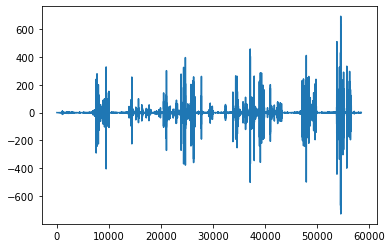

In [9]:
plt.plot(ts_dft.ravel())
plt.show()

In [10]:
kmeans_dft = KMeans(n_clusters=7, n_init=10, max_iter=100)
kmeans_dft.fit(np.squeeze(ts_dft))

KMeans(max_iter=100, n_clusters=7, n_init=10)

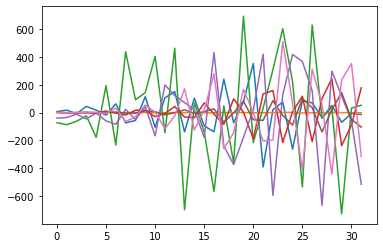

In [11]:
plt.plot(np.squeeze(kmeans_dft.cluster_centers_).T)
plt.show()

In [9]:
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

/Applications/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/Applications/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/Applications/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


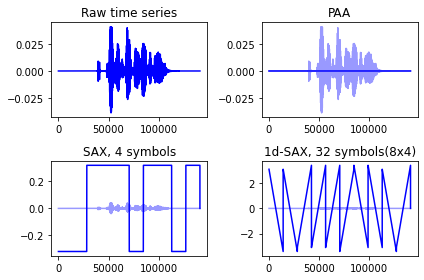

In [39]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 10#fare un po di ricerca 
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(data_nonull_col)
paa_dataset_inv = paa.inverse_transform(ts_paa)

# SAX transform
n_sax_symbols = 4#di solito 4 
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, 
                                     alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(data_nonull_col)
sax_dataset_inv = sax.inverse_transform(ts_sax)

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 4
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)

ts_sax1d = one_d_sax.fit_transform(data_nonull_col)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(ts_sax1d)

plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(data_nonull_col[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(data_nonull_col[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(data_nonull_col[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(data_nonull_col[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

In [15]:
from tslearn.clustering import TimeSeriesKMeans# euclidean distance 


In [16]:
from pyts.metrics import dtw as dtw2
from sklearn.metrics import silhouette_score

### DFT CLUSTERING

In [42]:
# Faccio il calcolo dell'SSE e della silohuette
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=5, random_state=0)
    km.fit(ts_dft)
    sse.append(km.inertia_) #serve piccola
    label = km.labels_
    sil_coeff = silhouette_score(data_nonull_col, label, metric='euclidean')
    silhouette.append(sil_coeff)
    km_list.append(km)    

KeyboardInterrupt: 

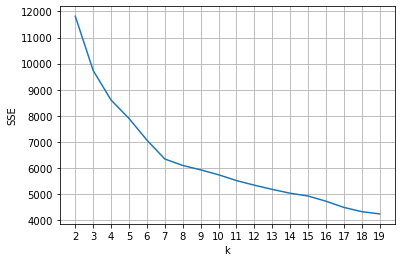

In [24]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, sse)
plt.grid()
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

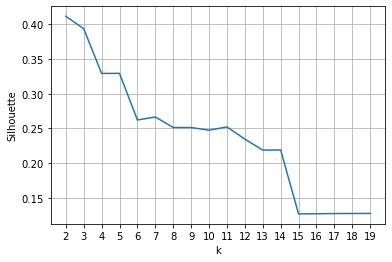

In [25]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, silhouette)
plt.grid()
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

In [29]:
km_list

[TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=2, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=4, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=6, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=7, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=8, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=9, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=10, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=11, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=12, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=13, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=14, random_state=0),
 TimeSeriesKMeans(max_iter=5, metr

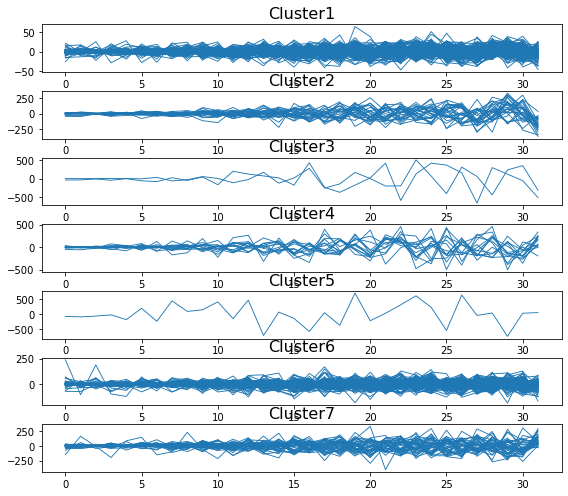

In [30]:
plt.figure(figsize=(8,7))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7']):
    plt.subplot(7, 1, i + 1)
    for x in ts_dft[km_list[5].labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [44]:
#Un po' diversa rispetto alla precedente perché la distanza euclidea non è la migliore per 
# fare il clustering
km_dft = TimeSeriesKMeans(n_clusters=7, metric="dtw", max_iter=5, random_state=0)
cluster_labels = km_dft.fit_transform(ts_dft)


/Applications/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


array([0, 0, 0, ..., 0, 0, 0])

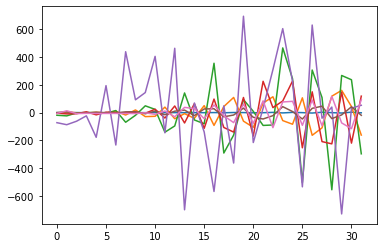

In [34]:
plt.plot(np.squeeze(km_dft.cluster_centers_).T)
plt.show()

In [50]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_dft.labels_, df_train['emotion'])


In [51]:
cross_tab

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
row_0,,,,,,,,
0,212,276,131,221,244,140,260,129
1,10,0,0,8,6,0,1,2
2,0,0,0,1,1,0,0,0
3,3,0,1,2,5,0,2,1
4,0,0,0,1,0,0,0,0
5,42,4,8,35,20,0,12,11
6,13,0,4,12,4,0,5,1


In [52]:
cross_tab = pd.crosstab(km_dft.labels_, df_train['vocal_channel'])


In [53]:
cross_tab

vocal_channel,song,speech
row_0,,
0,661,952
1,8,19
2,0,2
3,5,9
4,0,1
5,65,67
6,9,30


In [54]:
cross_tab = pd.crosstab(km_dft.labels_, df_train['emotional_intensity'])


In [55]:
cross_tab

emotional_intensity,normal,strong
row_0,,
0,928,685
1,3,24
2,1,1
3,1,13
4,0,1
5,45,87
6,6,33


In [88]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_dft.labels_, df_train['sex'])
cross_tab

sex,F,M
row_0,,
0,834,779
1,7,20
2,0,2
3,7,7
4,0,1
5,36,96
6,8,31


### CLUSTERING SAX 

In [8]:
# SAX transform
n_sax_symbols = 8 #di solito 4 

sax = SymbolicAggregateApproximation(n_segments=8, 
                                     alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(data_nonull_col)
sax_dataset_inv = sax.inverse_transform(ts_sax)


/Applications/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [12]:
ts_sax.shape

(1828, 8, 1)

In [9]:
ts_sax = ts_sax.reshape(1828,8)

In [20]:
ts_sax

array([[3, 3, 4, ..., 3, 4, 4],
       [4, 3, 3, ..., 4, 3, 4],
       [4, 3, 4, ..., 3, 4, 3],
       ...,
       [3, 3, 4, ..., 4, 3, 4],
       [4, 4, 3, ..., 4, 3, 3],
       [3, 4, 4, ..., 3, 4, 3]])

In [21]:
# Faccio il calcolo dell'SSE e della silohuette
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    km_sax = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=5, random_state=0)
    km_sax.fit(ts_sax)
    sse.append(km_sax.inertia_) #serve piccola
    label = km_sax.labels_
    sil_coeff = silhouette_score(ts_sax, label, metric='euclidean')
    silhouette.append(sil_coeff)
    km_list.append(km_sax)    

/Applications/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'ModuleNotFoundError(No module named 'awkward._connect.numba')'.
  entrypoints.init_all()


In [22]:
ts_sax

array([[3, 3, 4, ..., 3, 4, 4],
       [4, 3, 3, ..., 4, 3, 4],
       [4, 3, 4, ..., 3, 4, 3],
       ...,
       [3, 3, 4, ..., 4, 3, 4],
       [4, 4, 3, ..., 4, 3, 3],
       [3, 4, 4, ..., 3, 4, 3]])

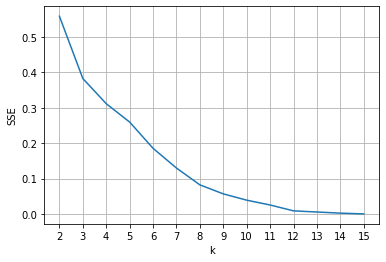

In [27]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, sse)
plt.grid()
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

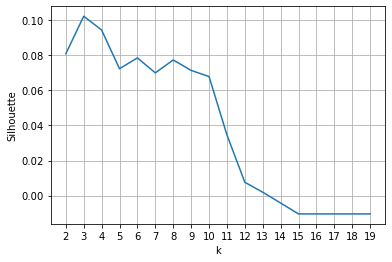

In [28]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, silhouette)
plt.grid()
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

In [25]:
 km_list

[TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=2, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=4, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=6, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=7, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=8, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=9, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=10, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=11, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=12, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=13, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=14, random_state=0),
 TimeSeriesKMeans(max_iter=5, metr

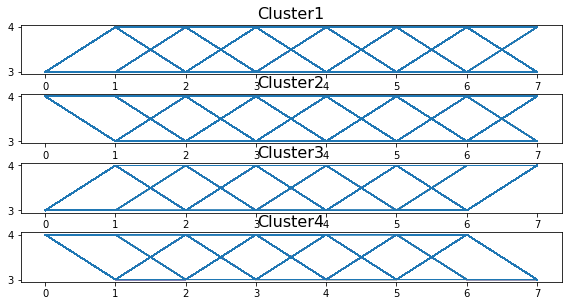

In [30]:
plt.figure(figsize=(8,7))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']):
    plt.subplot(7, 1, i + 1)
    for x in ts_sax[km_list[2].labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [31]:
km_sax = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=5, random_state=0)
km_sax.fit(ts_sax)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=4, random_state=0)

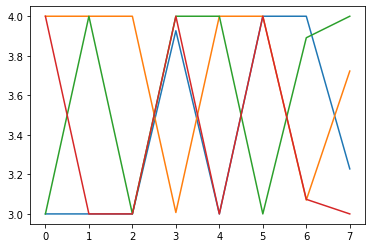

In [32]:
plt.plot(np.squeeze(km_sax.cluster_centers_).T)
plt.show()

In [33]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_sax.labels_, df_train['emotion'])
cross_tab

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
row_0,,,,,,,,
0,77,90,34,87,83,45,82,32
1,100,99,55,98,88,48,113,63
2,43,43,21,50,57,20,34,27
3,60,48,34,45,52,27,51,22


In [34]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_sax.labels_, df_train['vocal_channel'])
cross_tab

vocal_channel,song,speech
row_0,,
0,215,315
1,276,388
2,130,165
3,127,212


In [35]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_sax.labels_, df_train['emotional_intensity'])
cross_tab

emotional_intensity,normal,strong
row_0,,
0,278,252
1,364,300
2,160,135
3,182,157


In [36]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_sax.labels_, df_train['sex'])
cross_tab

sex,F,M
row_0,,
0,238,292
1,347,317
2,132,163
3,175,164


### CLUSTER PAA

In [10]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 10#fare un po di ricerca 
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(data_nonull_col)
paa_dataset_inv = paa.inverse_transform(ts_paa)

/Applications/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [11]:
ts_paa = ts_paa.reshape(1828,10)

In [42]:
# Faccio il calcolo dell'SSE e della silohuette
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    km_paa = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=5, random_state=0)
    km_paa.fit(ts_paa)
    sse.append(km_paa.inertia_) #serve piccola
    label = km_paa.labels_
    sil_coeff = silhouette_score(ts_paa, label, metric='euclidean')
    silhouette.append(sil_coeff)
    km_list.append(km_paa)    

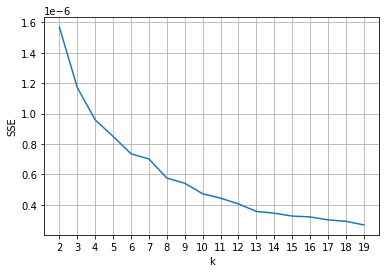

In [43]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, sse)
plt.grid()
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

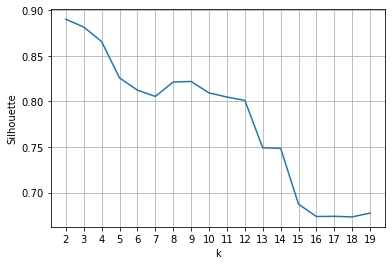

In [44]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, silhouette)
plt.grid()
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

In [45]:
km_list

[TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=2, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=4, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=6, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=7, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=8, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=9, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=10, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=11, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=12, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=13, random_state=0),
 TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=14, random_state=0),
 TimeSeriesKMeans(max_iter=5, metr

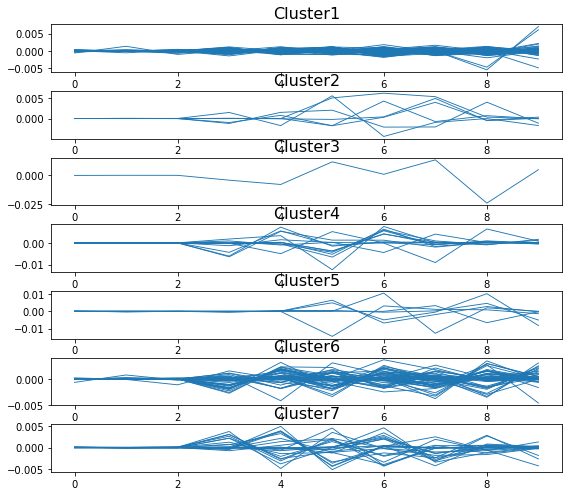

In [47]:
plt.figure(figsize=(8,7))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7']):
    plt.subplot(7, 1, i + 1)
    for x in ts_paa[km_list[5].labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [53]:
km_paa = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=5, random_state=0)
km_paa.fit(ts_paa)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=6, random_state=0)

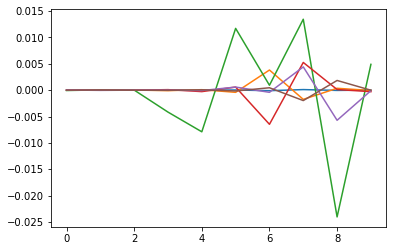

In [54]:
plt.plot(np.squeeze(km_paa.cluster_centers_).T)
plt.show()

In [55]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_paa.labels_, df_train['emotion'])
cross_tab

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
row_0,,,,,,,,
0,245,279,136,248,260,140,271,136
1,4,0,1,6,5,0,1,1
2,0,0,0,1,0,0,0,0
3,5,0,1,3,2,0,0,1
4,3,0,1,4,3,0,1,0
5,23,1,5,18,10,0,7,6


In [56]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_paa.labels_, df_train['vocal_channel'])
cross_tab

vocal_channel,song,speech
row_0,,
0,702,1013
1,8,10
2,0,1
3,1,11
4,2,10
5,35,35


In [57]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_paa.labels_, df_train['emotional_intensity'])
cross_tab

emotional_intensity,normal,strong
row_0,,
0,962,753
1,6,12
2,0,1
3,0,12
4,0,12
5,16,54


In [58]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(km_paa.labels_, df_train['sex'])
cross_tab

sex,F,M
row_0,,
0,860,855
1,5,13
2,0,1
3,4,8
4,4,8
5,19,51


### Clustering sulle feature 

In [12]:
import scipy.stats as stats

In [13]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        #'med': np.median(values),
        #'10p': np.percentile(values, 10),
        #'25p': np.percentile(values, 25),
        #'50p': np.percentile(values, 50),
        #'75p': np.percentile(values, 75),
        #'90p': np.percentile(values, 90),
        #'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        #'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }
    
    return features

In [14]:
from sklearn.cluster import KMeans


In [15]:
set_feature = []
for x in data_nonull_col:
    set_feature.append(calculate_features(x))
C = list(set_feature)
# In F metto il calculated features function (vista sopra con avarage, mean ecc)
#F = [list(calculate_features(x).values())[:-2] for x in X]
F = [list(calculate_features(x).values()) for x in data_nonull_col]

KeyboardInterrupt: 

In [68]:
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(F)
    sse.append(kmeans.inertia_) #serve piccola
    label = kmeans.labels_
    sil_coeff = silhouette_score(F, label, metric='euclidean')
    silhouette.append(sil_coeff)
    km_list.append(kmeans)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anacon

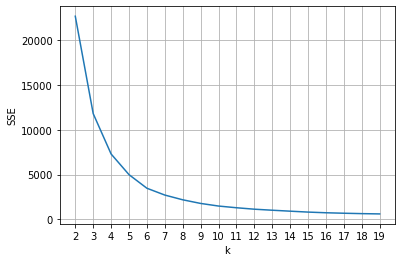

In [69]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, sse)
plt.grid()
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

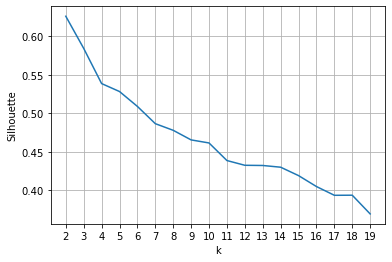

In [70]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, silhouette)
plt.grid()
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

In [72]:
km_list

[KMeans(n_clusters=2),
 KMeans(n_clusters=3),
 KMeans(n_clusters=4),
 KMeans(n_clusters=5),
 KMeans(n_clusters=6),
 KMeans(n_clusters=7),
 KMeans(),
 KMeans(n_clusters=9),
 KMeans(n_clusters=10),
 KMeans(n_clusters=11),
 KMeans(n_clusters=12),
 KMeans(n_clusters=13),
 KMeans(n_clusters=14),
 KMeans(n_clusters=15),
 KMeans(n_clusters=16),
 KMeans(n_clusters=17),
 KMeans(n_clusters=18),
 KMeans(n_clusters=19)]

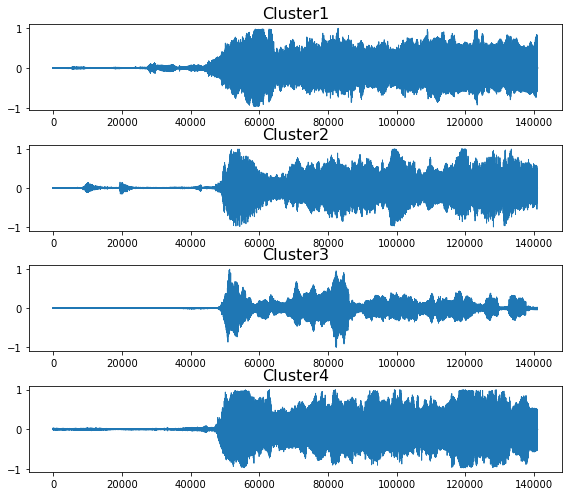

In [75]:
plt.figure(figsize=(8,7))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']):
    plt.subplot(4, 1, i + 1)
    for x in data_nonull_col[km_list[2].labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [78]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(F)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

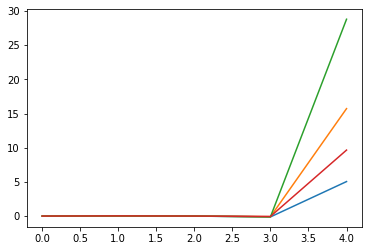

In [79]:
plt.plot(np.squeeze(kmeans.cluster_centers_).T)
plt.show()

In [80]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(kmeans.labels_, df_train['emotion'])
cross_tab

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
row_0,,,,,,,,
0,91,196,46,123,144,83,150,39
1,45,28,27,47,35,25,44,28
2,10,5,12,6,4,3,11,4
3,134,51,59,104,97,29,75,73


In [82]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(kmeans.labels_, df_train['vocal_channel'])
cross_tab

vocal_channel,song,speech
row_0,,
0,560,312
1,20,259
2,0,55
3,168,454


In [84]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(kmeans.labels_, df_train['emotional_intensity'])
cross_tab

emotional_intensity,normal,strong
row_0,,
0,507,365
1,150,129
2,33,22
3,294,328


In [85]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(kmeans.labels_, df_train['sex'])
cross_tab

sex,F,M
row_0,,
0,493,379
1,90,189
2,11,44
3,298,324


### Clustering gerarchico

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z1 = linkage(ts_paa, method='single', metric='euclidean')
Z2 = linkage(ts_paa, method='complete', metric='euclidean')
Z3 = linkage(ts_paa, method='ward', metric='euclidean')

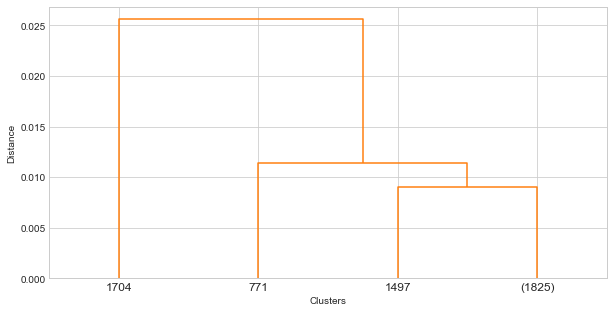

In [17]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z1, color_threshold=113, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

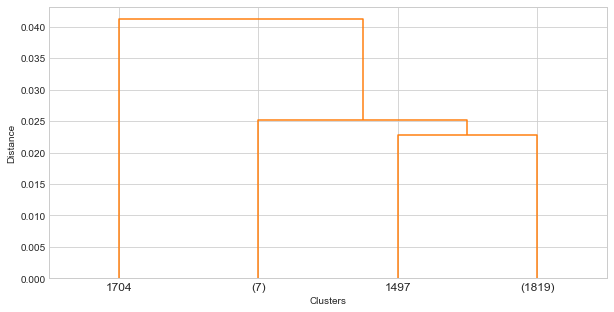

In [18]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z2, color_threshold=5, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

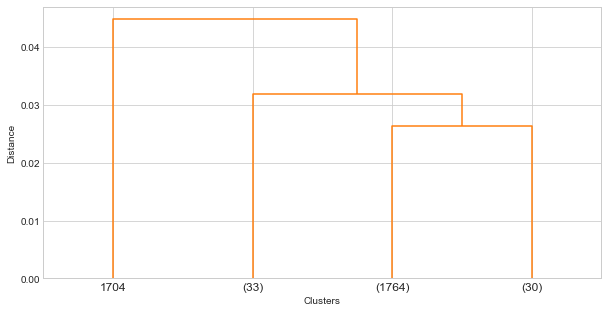

In [19]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z3, color_threshold=10, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z1 = linkage(ts_sax, method='single', metric='euclidean')
Z2 = linkage(ts_sax, method='complete', metric='euclidean')
Z3 = linkage(ts_sax, method='ward', metric='euclidean')

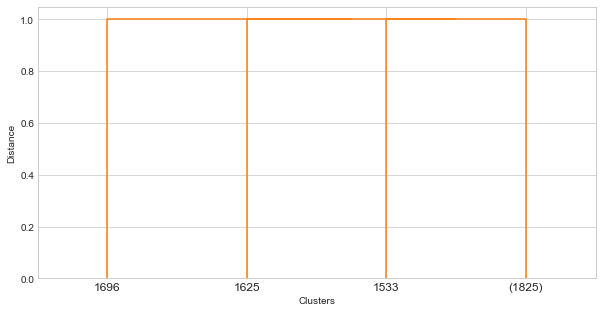

In [21]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z1, color_threshold=113, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

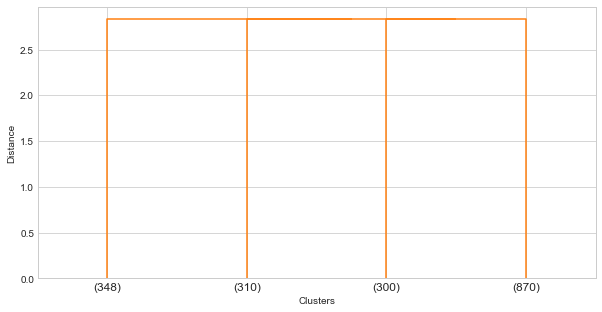

In [22]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z2, color_threshold=5, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

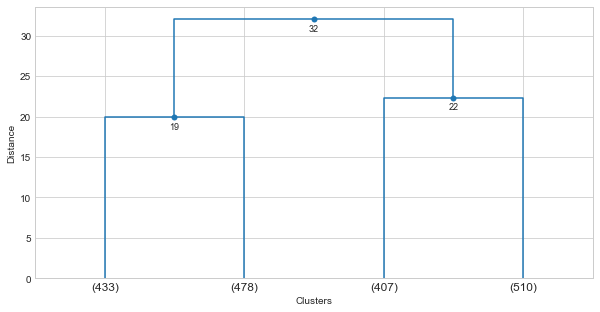

In [23]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z3, color_threshold=10, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z1 = linkage(ts_paa, method='single', metric='euclidean')
Z2 = linkage(ts_paa, method='complete', metric='euclidean')
Z3 = linkage(ts_paa, method='ward', metric='euclidean')

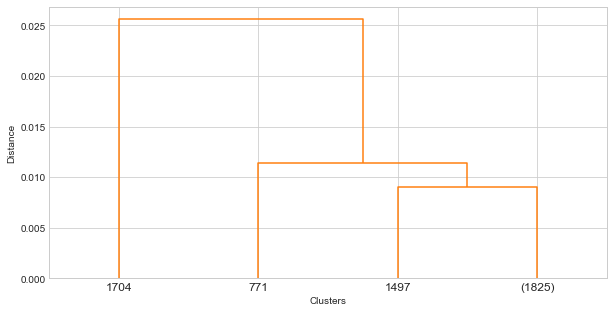

In [25]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z1, color_threshold=113, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

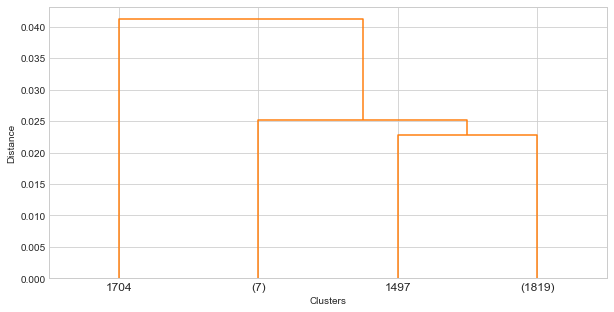

In [26]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z2, color_threshold=113, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

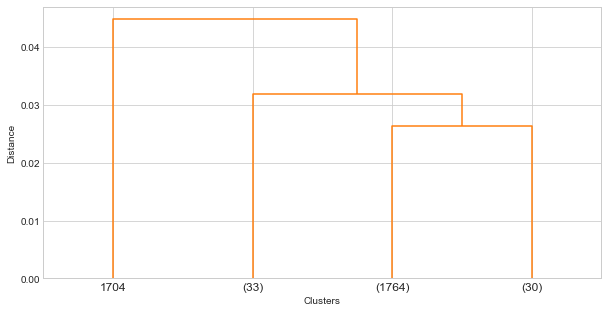

In [27]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z3, color_threshold=113, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)

Metodo di Davide

In [17]:
#Funzione per stampare i dendogrammi relativi ad un determinato modello

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### SAX

Complete

In [19]:
# setting distance_threshold=0 ensures we compute the full tree.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(ts_sax)  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [20]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

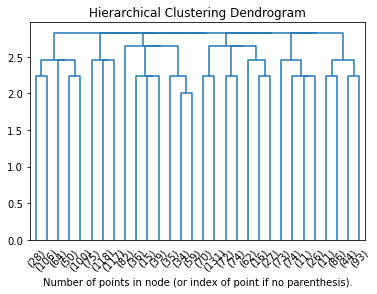

In [21]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Single

In [23]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model = model.fit(ts_sax) 

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [24]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

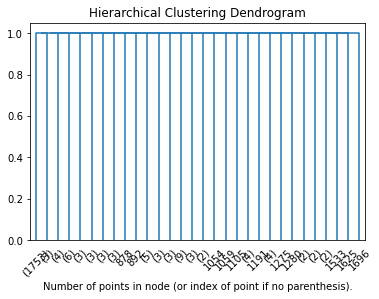

In [25]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Ward

In [26]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model = model.fit(ts_sax) 

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [27]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

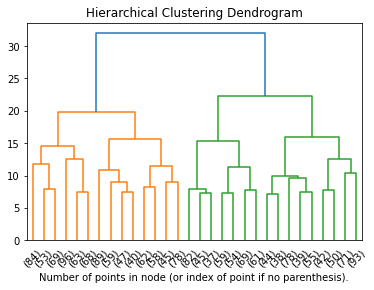

In [28]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### PAA

Complete

In [29]:
# setting distance_threshold=0 ensures we compute the full tree.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(ts_paa)  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [30]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

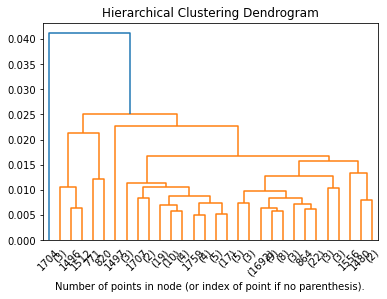

In [31]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Single

In [35]:
# setting distance_threshold=0 ensures we compute the full tree.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model = model.fit(ts_paa)  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [36]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

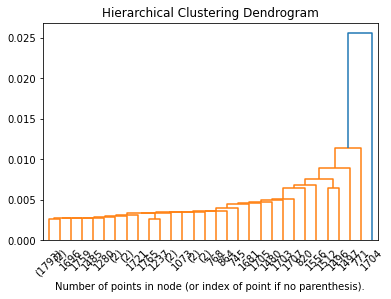

In [37]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Ward

In [38]:
# setting distance_threshold=0 ensures we compute the full tree.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model = model.fit(ts_paa)  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [39]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

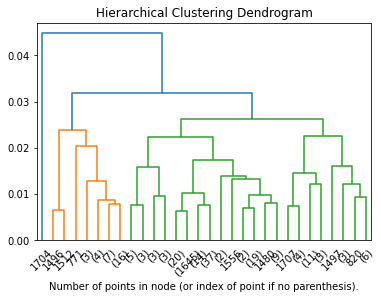

In [40]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### DFT

Complete

In [42]:
# setting distance_threshold=0 ensures we compute the full tree.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(ts_dft)  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [43]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

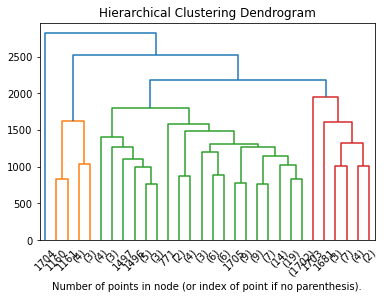

In [44]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Single

In [45]:
# setting distance_threshold=0 ensures we compute the full tree.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model = model.fit(ts_dft)  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [46]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

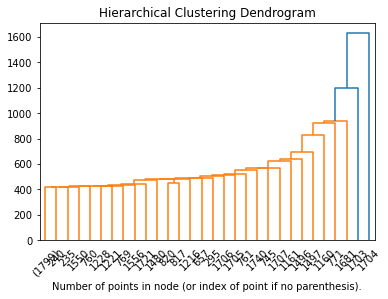

In [47]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [49]:
# setting distance_threshold=0 ensures we compute the full tree.
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model = model.fit(ts_dft)  

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [50]:
pd.value_counts(model.labels_)

0       1
629     1
625     1
623     1
621     1
       ..
1210    1
1208    1
1206    1
1204    1
1827    1
Length: 1828, dtype: int64

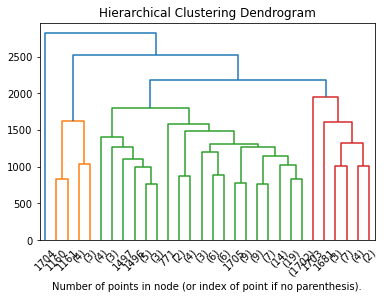

In [51]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Reputo il migliore ward con sax 

In [54]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering( n_clusters=4, affinity='euclidean', linkage='ward')
model = model.fit(ts_sax) 

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [56]:
from sklearn.metrics import silhouette_score

print('silhouette', silhouette_score(ts_sax, model.labels_))
pd.value_counts(model.labels_)

silhouette 0.11377275103920333


0    510
1    478
3    433
2    407
dtype: int64

In [57]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(model.labels_, df_train['sex'])
cross_tab

sex,F,M
row_0,,
0,266,244
1,212,266
2,225,182
3,189,244


In [58]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(model.labels_, df_train['emotion'])
cross_tab

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
row_0,,,,,,,,
0,55,78,49,75,81,40,88,44
1,91,62,27,80,77,33,73,35
2,62,61,34,68,59,36,62,25
3,72,79,34,57,63,31,57,40


In [59]:
# Crea la tabella incrociata tra cluster e feature
cross_tab = pd.crosstab(model.labels_, df_train['emotional_intensity'])
cross_tab

emotional_intensity,normal,strong
row_0,,
0,270,240
1,252,226
2,231,176
3,231,202
